In [232]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [233]:
acceptance = pd.read_csv('Globepay Acceptance Report - Globepay Acceptance Report.csv')
chargeback = pd.read_csv('Globepay Chargeback Report - Globepay Chargeback Report.csv')

# Some basic exploration

In [234]:
acceptance.head()

,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates
0,nCyEIIGaP5QQ2Wqb-_Rt8,True,GLOBALPAY,evt_1ESgcCOV7fY1ChY1MkZizZt,2019-01-01T00:00:00.000Z,DECLINED,False,1020.46,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
1,ptNiI9B7NNpK7VsMZx6zZ,True,GLOBALPAY,evt_1EBMGCEjEtianKMJaZXOx1y,2019-01-01T04:48:00.000Z,ACCEPTED,False,1582.57,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
2,1GS5BDKBnauCt-3nHPs6x,True,GLOBALPAY,evt_1EOALu0AZqEhZBn9ub_nbcE,2019-01-01T09:36:00.000Z,DECLINED,False,1653.07,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
3,Y_oecYz8GjBDaxmMqkkLQ,True,GLOBALPAY,evt_1ESHsWyaSPqE1mrmJ2B6rvs,2019-01-01T14:24:00.000Z,ACCEPTED,False,2228.17,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."
4,LlEs1TnKVa2xX6PH9Zsz0,True,GLOBALPAY,evt_1EjzPk13qLzmvDR_4hXuMMw,2019-01-01T19:12:00.000Z,ACCEPTED,False,2589.92,US,USD,"{""CAD"":1.415,""EUR"":0.926,""MXN"":25.103,""USD"":1,..."


In [235]:
acceptance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   external_ref  5430 non-null   object 
 1   status        5430 non-null   bool   
 2   source        5430 non-null   object 
 3   ref           5430 non-null   object 
 4   date_time     5430 non-null   object 
 5   state         5430 non-null   object 
 6   cvv_provided  5430 non-null   bool   
 7   amount        5430 non-null   float64
 8   country       5430 non-null   object 
 9   currency      5430 non-null   object 
 10  rates         5430 non-null   object 
dtypes: bool(2), float64(1), object(8)
memory usage: 392.5+ KB


In [236]:
acceptance.describe()

,amount
count,5430.000000
mean,86938.605757
std,50327.853421
min,-23.780000
25%,42481.355000
50%,85488.025000
75%,128548.397500
max,180371.520000


There is one transaction with negative amount, but its 'state' is 'accepted' so we don't investigate it further


In [237]:
print(f'Number of transaction with negative amount: {(acceptance.amount < 0).sum()}')
acceptance[acceptance.amount < 0]

Number of transaction with negative amount: 1


,external_ref,status,source,ref,date_time,state,cvv_provided,amount,country,currency,rates
11,SPm_aqm_Rrer_6jxpLvO2,True,GLOBALPAY,evt_1EhCNv4mRDFQzT2r2O5Cy5G,2019-01-01T04:48:00.000Z,ACCEPTED,False,-23.78,UK,GBP,"{""CAD"":1.4173511828553305,""EUR"":0.922579749754..."


Convert transaction amount to new column in USD / Total amount of declined transactions in USD

In [238]:
# Creat usd_amount column for each transaction
def conversion_rate(row):
    rate = json.loads(row.rates)
    usd_amount = row.amount / rate[row.currency]
    return usd_amount

acceptance['usd_amount'] = acceptance.apply(conversion_rate, axis=1)

# total amount of declined transactions in USD
print(acceptance[acceptance.state == 'DECLINED'].usd_amount.sum())


130877578.83076099


Whether there is only a single type of currency used in each country

In [239]:
for c in acceptance.country.unique():
    print(f'{c}: {acceptance[acceptance.country == c].currency.nunique() == 1}') 

US: True
MX: True
UK: True
FR: True
CA: True
AE: True


Overall acceptance rate


In [240]:
# verification
print("Dataset only contains 'accept' and 'declined' two states:", acceptance.state.nunique() == 2)
print(f"Overall acceptance rate: {(acceptance.state == 'ACCEPTED').sum()/acceptance.shape[0] * 100:.3f}")

Dataset only contains 'accept' and 'declined' two states: True
Overall acceptance rate: 69.558


# Answers for question 2
Note that exploration for question 1 is after this section

### 2.1 Acceptance rate over time

In [241]:
# Prepare date time data
acceptance['date_time'] = pd.to_datetime(acceptance['date_time'])
acceptance.index = pd.to_datetime(acceptance['date_time'])
# Turn 'state' column into binary digit for ease of further process
acceptance['binary_state'] = acceptance.state.apply(lambda x: 1 if x == 'ACCEPTED' else 0)

Weekly base and monthly base

[]

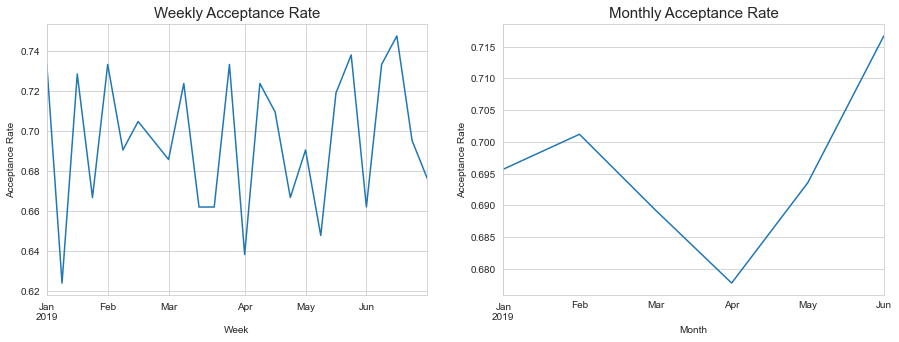

In [242]:
# AR = acceptance rate
sns.set_style('whitegrid')
weeklyAR = acceptance.binary_state.resample('W').mean()
monthlyAR = acceptance.binary_state.resample('M').mean()

fig,[ax1, ax2] = plt.subplots(nrows=1,ncols=2, figsize = (15,5))

weeklyAR.plot(ax=ax1).set(xlabel="Week", ylabel="Acceptance Rate")
ax1.set_title("Weekly Acceptance Rate", fontsize = 15)

monthlyAR.plot(ax=ax2).set(xlabel="Month", ylabel="Acceptance Rate")
ax2.set_title("Monthly Acceptance Rate", fontsize = 15)

plt.plot() 


Week day base

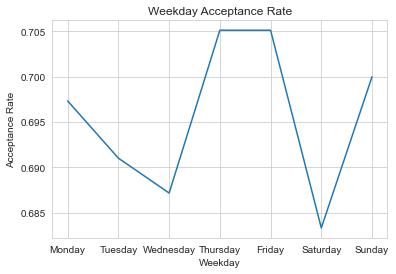

In [243]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
weekdayAR = acceptance.groupby(acceptance['date_time'].dt.weekday).binary_state.mean()
weekdayAR.index = days
plt.title('Weekday Acceptance Rate')
weekdayAR.plot().set(xlabel="Weekday", ylabel="Acceptance Rate")
plt.show()

### 2.2 List of countries where the amount of declined transactions went over $25M

In [244]:
# Verify countries
print(f'Countries in the dataset: {sorted(acceptance.country.unique())}')
print(f'Is there any null value in "country" column: {acceptance.country.isnull().values.any()}')

# List of countries where the amount of declined transactions went over $25M
countries = [k for k, v in (acceptance[acceptance.state == 'DECLINED'].groupby('country').usd_amount.sum() > 25000000).items() if v]
print(f'Counties where the amount of declined transactions went over $25M: {sorted(countries)}')



Countries in the dataset: ['AE', 'CA', 'FR', 'MX', 'UK', 'US']
Is there any null value in "country" column: False
Counties where the amount of declined transactions went over $25M: ['AE', 'FR', 'UK', 'US']


### 2.3 Missing chargeback data

In [245]:
# Check if two dataset have identical set of external_ref
print(f'Identical Exteranl Ref in both dataset? {set(acceptance.external_ref.to_list()) == set(chargeback.external_ref.to_list())}')

# Merge chargeback status to the acceptance report
merge_data = pd.merge(acceptance, chargeback[['external_ref', 'chargeback']], on='external_ref', how='left')

# Check if there is chargeback data that's missing in the merge file
print(f'Chargeback missing case count after merged: {merge_data.chargeback.isna().sum()}')

Identical Exteranl Ref in both dataset? True
Chargeback missing case count after merged: 0


# Exploring answers for question one

- the problem root causes
- suggested solutions / recommendations
- list of further next steps (hypothesis / analysis) you would do as a next steps having more time and business knowledge

Acceptance rate across currencies

In [246]:
# by country, by currency, by cvv_provided, by usd_amount range, by time of hour, by source?
# Total AR by currency
acceptance.groupby('currency').binary_state.agg(case_count = 'count', acceptance_rate = 'mean')


,case_count,acceptance_rate
currency,,
CAD,905,0.696133
EUR,905,0.700552
GBP,905,0.714917
MXN,905,0.711602
USD,1810,0.675138


Acceptance rate across countries

In [247]:
# Total AR by country
acceptance.groupby('country').binary_state.agg(case_count = 'count', acceptance_rate = 'mean')


,case_count,acceptance_rate
country,,
AE,905,0.678453
CA,905,0.696133
FR,905,0.700552
MX,905,0.711602
UK,905,0.714917
US,905,0.671823


Acceptance rate through every hour by country

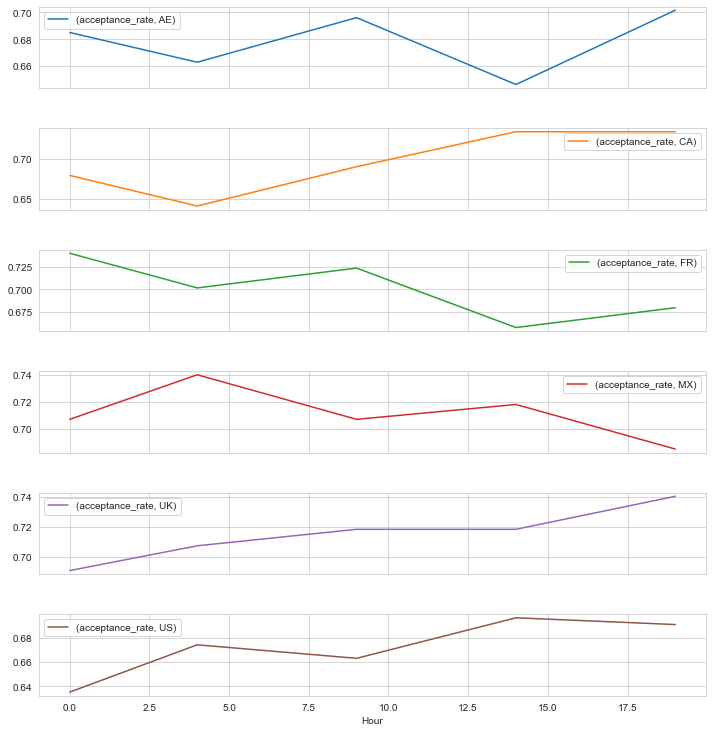

In [248]:

hourlyAR_country = acceptance.groupby(['country', acceptance['date_time'].dt.hour]).binary_state.agg(acceptance_rate = 'mean')
ax = hourlyAR_country.unstack(level=0).plot(kind='line', subplots=True, rot=0, figsize=(10, 20), layout=(12, 1), xlabel='Hour')
plt.tight_layout()


Acceptance rate through month by country

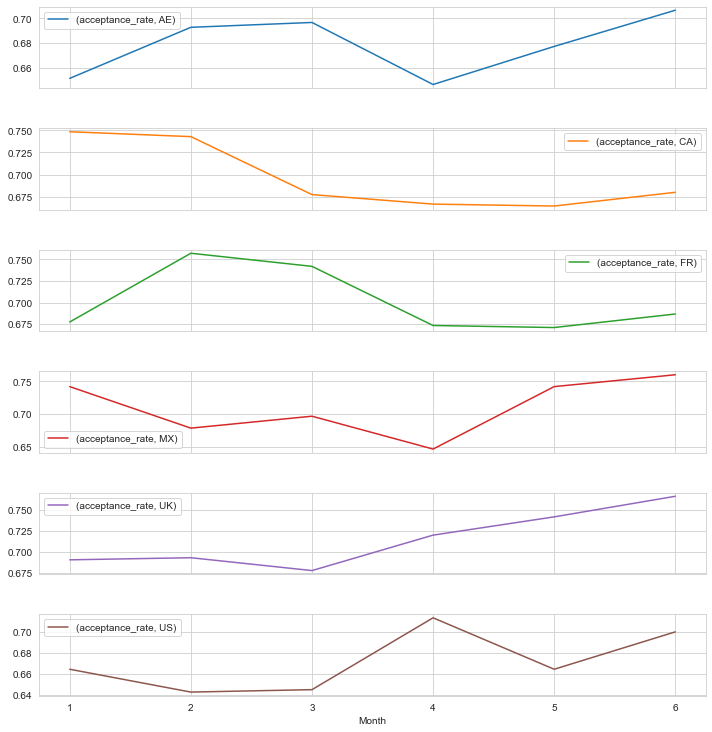

In [249]:
monththlyAR_country = acceptance.groupby(['country', acceptance['date_time'].dt.month]).binary_state.agg(acceptance_rate = 'mean')
ax = monththlyAR_country.unstack(level=0).plot(kind='line', subplots=True, rot=0, figsize=(10, 20), layout=(12, 1), xlabel='Month')
plt.tight_layout()

Acceptance rate related to CVV provision status 

In [250]:
# ar by CVV provided
acceptance.groupby('cvv_provided').binary_state.agg(case_count = 'count', acceptance_rate = 'mean')


,case_count,acceptance_rate
cvv_provided,,
False,5390,0.696104
True,40,0.625000


Acceptance rate related to amount of transaction in USD

In [251]:
# AR by transaction amount

bins = np.append(np.arange(0, round(acceptance.usd_amount.max()), 50000), np.inf)

#AR_amount = acceptance.groupby(['country', pd.cut(acceptance.usd_amount, bins)]).binary_state.agg(case_count = 'count', acceptance_rate = 'mean')
AR_amount = acceptance.groupby(pd.cut(acceptance.usd_amount, bins)).binary_state.agg(case_count = 'count', acceptance_rate = 'mean')
AR_amount

,case_count,acceptance_rate
usd_amount,,
"(0.0, 50000.0]",2256,0.697252
"(50000.0, 100000.0]",1183,0.689772
"(100000.0, 150000.0]",1054,0.684061
"(150000.0, 200000.0]",622,0.713826
"(200000.0, 250000.0]",301,0.714286
"(250000.0, inf]",13,0.538462


[]

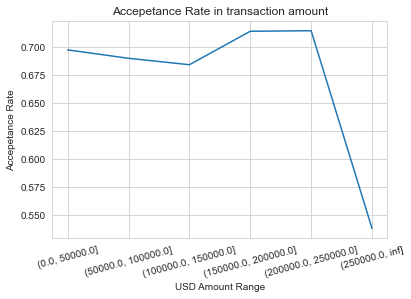

In [252]:

AR_amount.acceptance_rate.plot()
plt.title('Accepetance Rate in transaction amount')
plt.xticks(rotation=15)
plt.xlabel('USD Amount Range')
plt.ylabel('Accepetance Rate')
plt.plot()

Acceptance rate related to amount of transaction in USD (Exponetionally plot)

In [253]:
# AR by transaction amount 2
# add country
bins = np.array([10, 100, 1000, 10000, 100000, 1000000])

#AR_amount2 = acceptance.groupby(['country', pd.cut(acceptance.usd_amount, bins)]).binary_state.agg(case_count = 'count', acceptance_rate = 'mean')
AR_amount2 = acceptance.groupby(pd.cut(acceptance.usd_amount, bins)).binary_state.agg(case_count = 'count', acceptance_rate = 'mean')
AR_amount2

,case_count,acceptance_rate
usd_amount,,
"(10, 100]",9,0.666667
"(100, 1000]",150,0.726667
"(1000, 10000]",999,0.708709
"(10000, 100000]",2281,0.686541
"(100000, 1000000]",1990,0.696985


[]

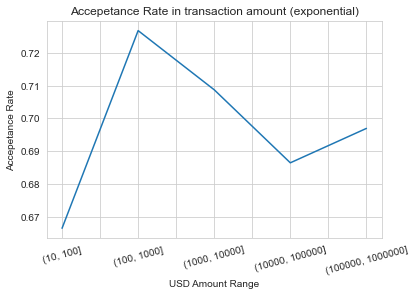

In [254]:
AR_amount2.acceptance_rate.plot()
plt.title('Accepetance Rate in transaction amount (exponential)')
plt.xticks(rotation=15)
plt.xlabel('USD Amount Range')
plt.ylabel('Accepetance Rate')
plt.plot()

Acceptance rate in different hour of a day

In [255]:
acceptance.groupby(acceptance['date_time'].dt.hour).binary_state.mean()


date_time
0     0.689687
4     0.687845
9     0.699816
14    0.695212
19    0.705341
Name: binary_state, dtype: float64

Declined total amount in different countries (in USD)

In [256]:
country_declined_amount = acceptance[acceptance.state == 'DECLINED'].groupby('country').usd_amount.sum().round(2)
country_declined_amount

country
AE    26335152.43
CA    18422315.65
FR    32628785.93
MX      876158.35
UK    27489496.69
US    25125669.78
Name: usd_amount, dtype: float64

Declined USD amount percentage plot in different country

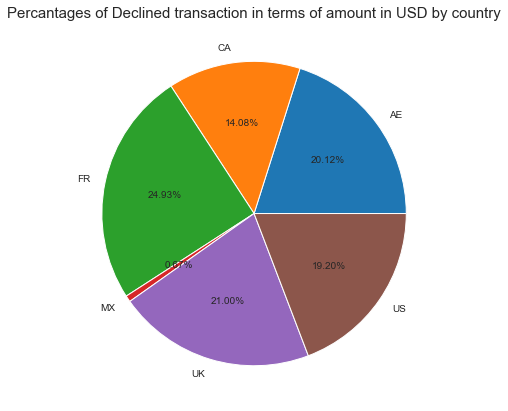

In [257]:
country_declined_amount.plot(kind = 'pie', autopct = '%.2f%%', figsize=(7,7)).set(ylabel='')
plt.title('Percantages of Declined transaction in terms of amount in USD by country', fontsize = 15)
plt.show()

Declined cases shared in different country

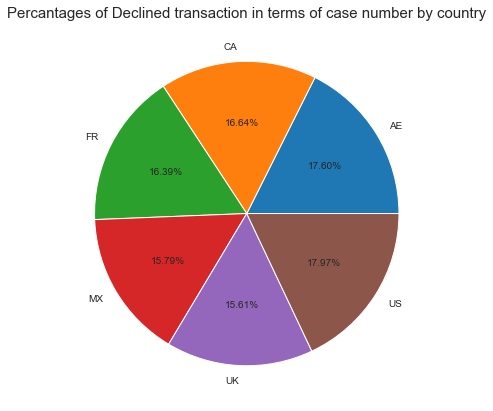

In [258]:
acceptance[acceptance.state == 'DECLINED'].groupby('country').size().plot(kind = 'pie', autopct = '%.2f%%', figsize=(7,7)).set(ylabel='')
plt.title('Percantages of Declined transaction in terms of case number by country', fontsize = 15)
plt.show()

Distribution of declined and accepted cases in different usd amount

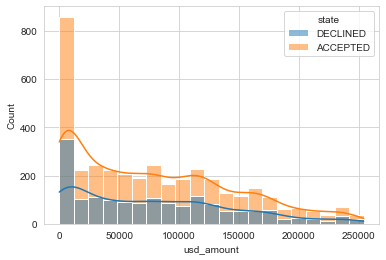

In [259]:
distribution = acceptance[['usd_amount', 'state', 'country', 'currency']].reset_index(drop=True)

ax = sns.histplot(data=distribution, x='usd_amount', hue='state', fill=True, kde=True)

plt.show()

Distribution of declined and accepted cases in different usd amount by country

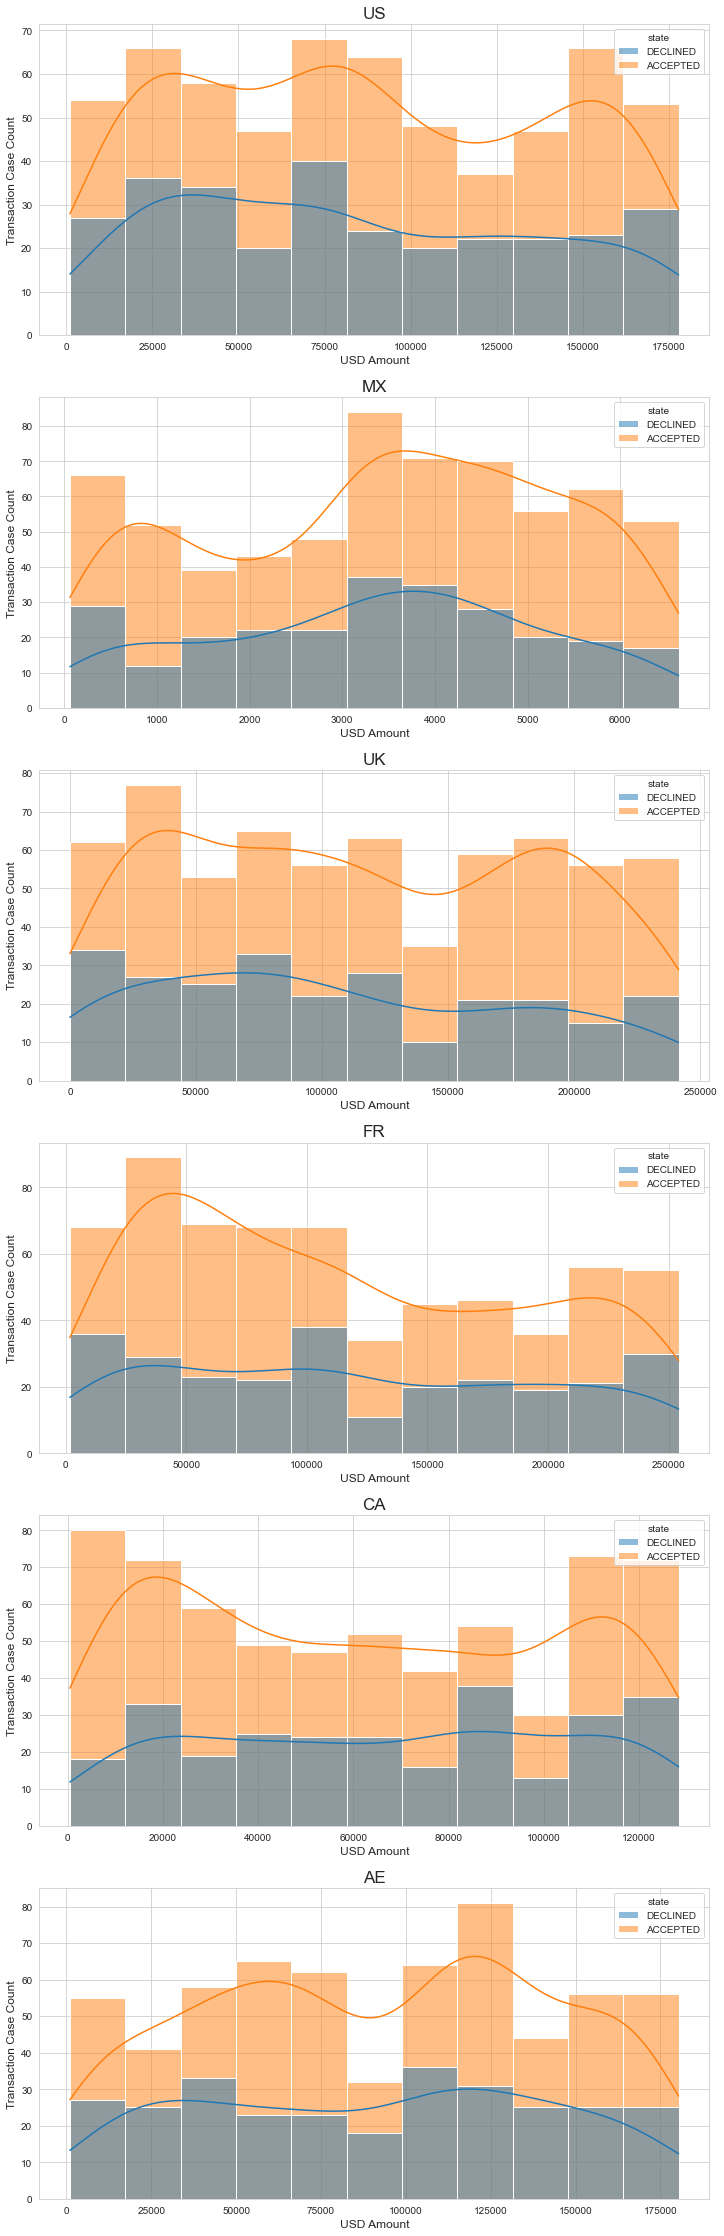

In [260]:
country_list = distribution.country.unique()
fig, axs = plt.subplots(nrows=len(country_list), ncols=1, figsize = (12,40))

hue_order = distribution.state.unique()
for i, c in enumerate(country_list):
    country_distribution = distribution[distribution.country == c]
    ax = sns.histplot(data=country_distribution, x='usd_amount', hue='state', fill=True, kde=True, ax=axs[i], hue_order=hue_order)
    sns.move_legend(ax, "upper right")
    axs[i].set_title(f'{c}', fontsize = 17)
    axs[i].set_xlabel('USD Amount', fontsize = 12)
    axs[i].set_ylabel('Transaction Case Count', fontsize = 12)
    axs[i].tick_params(axis='both', labelsize=10)

plt.subplots_adjust(hspace=0.2)
plt.show()

Distribution of declined and accepted cases in different usd amount by currency

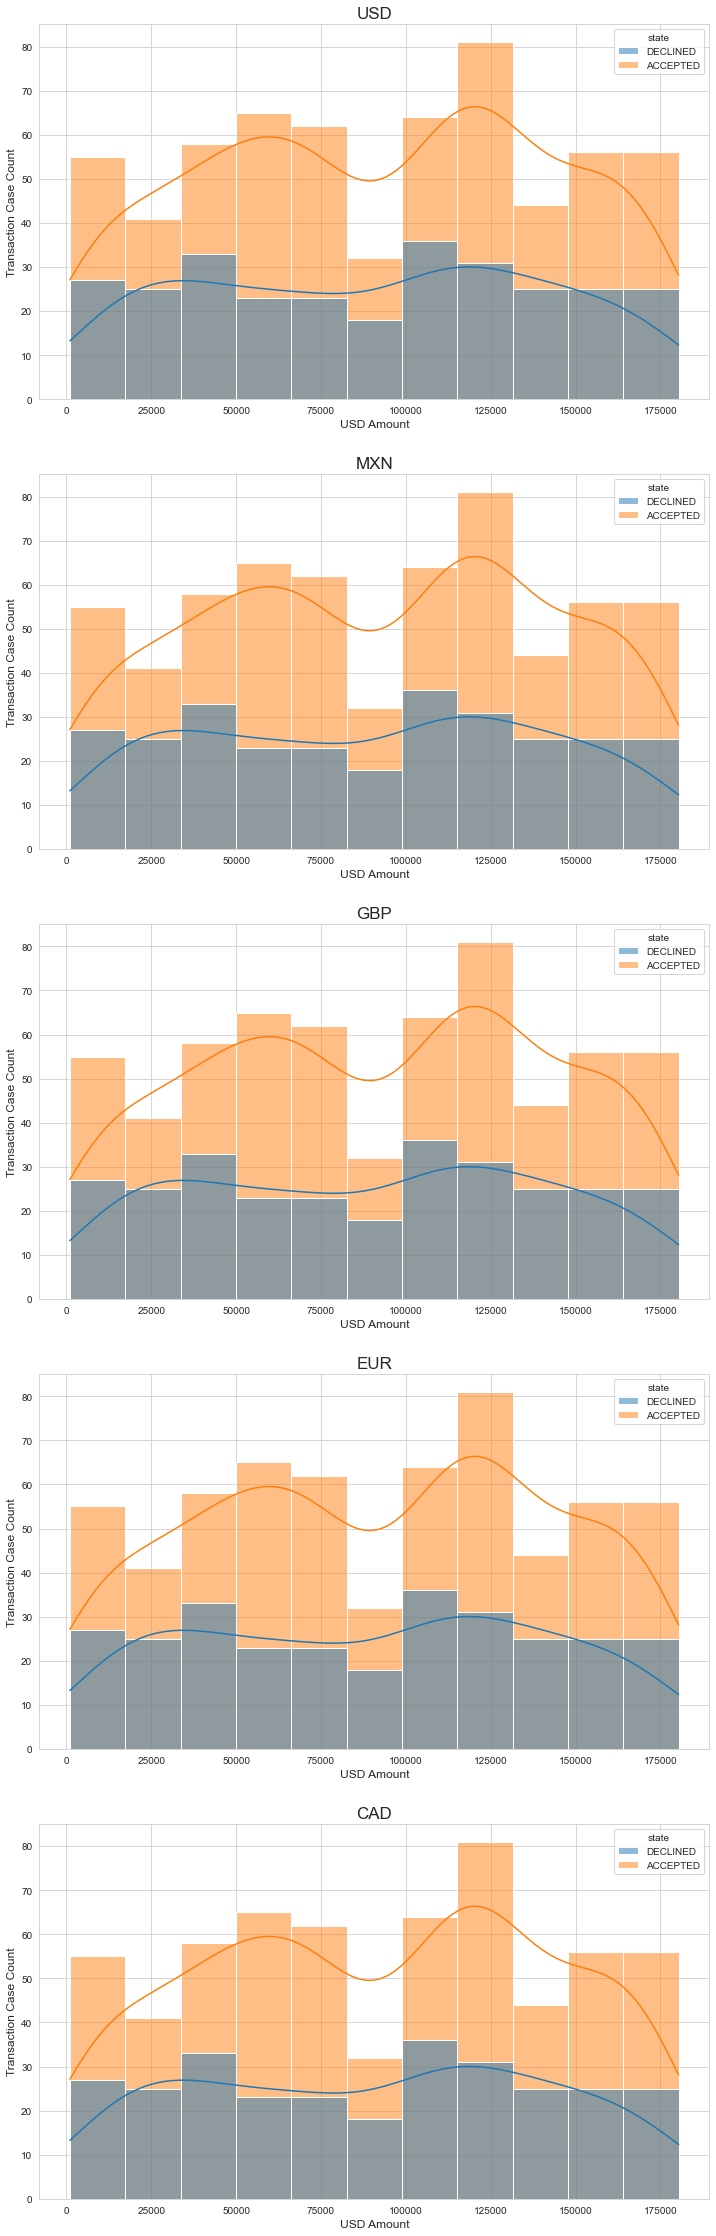

In [261]:
currency_list = distribution.currency.unique()
fig, axs = plt.subplots(nrows=len(currency_list), ncols=1, figsize = (12,40))

hue_order = distribution.state.unique()
for i, c in enumerate(currency_list):
    currency_distribution = distribution[distribution.currency == c]
    ax = sns.histplot(data=country_distribution, x='usd_amount', hue='state', fill=True, kde=True, ax=axs[i], hue_order=hue_order)
    sns.move_legend(ax, "upper right")
    axs[i].set_title(f'{c}', fontsize = 17)
    axs[i].set_xlabel('USD Amount', fontsize = 12)
    axs[i].set_ylabel('Transaction Case Count', fontsize = 12)
    axs[i].tick_params(axis='both', labelsize=10)

plt.subplots_adjust(hspace=0.2)
plt.show()